In [5]:
import pandas as pd
import numpy as np

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold, cross_validate
import matplotlib.pyplot as plt
import seaborn as sn

In [6]:
genreAll = pd.read_csv("/home/ibroto/Documents/UPF_SMC/ML/Lab1/Lab1/GenreAll.csv")
for col in genreAll.columns:
    genreAll.rename(columns={col:col.strip()}, inplace = True)
feat_30 = pd.read_csv("/home/ibroto/Documents/UPF_SMC/ML/Lab1/Lab1/features_30_sec.csv")
feat_3 = pd.read_csv("/home/ibroto/Documents/UPF_SMC/ML/Lab1/Lab1/features_3_sec.csv")


## Data Overview

Nbr of observations: 992
Nbr of features: 240
  Textual column : highlevel_speech_music_value (values: ['speech' 'music'])
  Textual column : highlevel_voice_instrumental_value (values: ['instrumental' 'voice'])
  Textual column : tonal_key_mode_value (values: ['major' 'minor'])
  Textual column : genre (values: ['blu' 'cla' 'cou' 'dis' 'hip' 'jaz' 'met' 'pop' 'reg' 'roc'])

Nbr of classes: 10


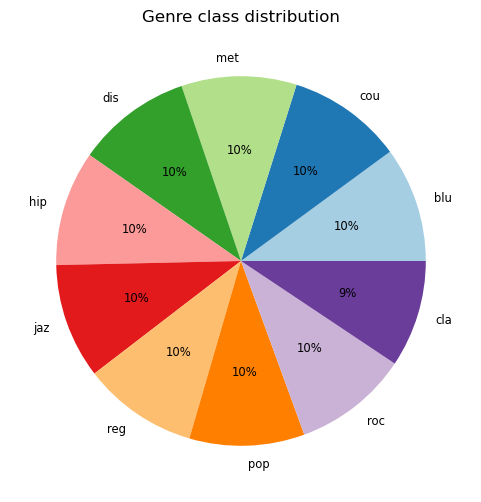

In [50]:
nrows, ncols = genreAll.shape
print(f"Nbr of observations: {nrows-1}\nNbr of features: {ncols-1}")

for col in genreAll.columns:
    if isinstance(genreAll[col][0], str): print(f'  Textual column : {col} (values: {genreAll[col].unique()})')

print(f"\nNbr of classes: {pd.unique(genreAll.genre).size}")

count_df = genreAll['genre'].value_counts().reset_index()
count_df.columns = ['values', 'counts']
fig, ax = plt.subplots(figsize=(24, 6))
colors = plt.cm.Paired.colors  # e.g. 'Paired', 'viridis', 'Set3', etc.

ax.pie(count_df.counts, labels=count_df['values'], autopct='%.0f%%',
       textprops={'size': 'smaller'}, radius=1,
       colors=colors[:len(count_df)])
plt.title('Genre class distribution')
plt.show()


In [51]:

#replace string-valued rows with 
genre_dict = {'blu':0, 'cla':1, 'cou':2, 'dis':3, 'hip':4, 'jaz':5, 'met':6, 'pop':7, 'reg':8,'roc':9}
highlevel_speech_music_value_dict = {'music':0, 'speech':1}
highlevel_voice_instrumental_value_dict = {'instrumental':0, 'voice':1}
tonal_key_mode_value_dict = {'minor':0, 'major':1}

genreAll['genre'] = genreAll['genre'].replace(genre_dict)
genreAll['highlevel_speech_music_value'] = genreAll['highlevel_speech_music_value'].replace(highlevel_speech_music_value_dict)
genreAll['highlevel_voice_instrumental_value'] = genreAll['highlevel_voice_instrumental_value'].replace(highlevel_voice_instrumental_value_dict)
genreAll['tonal_key_mode_value'] = genreAll['tonal_key_mode_value'].replace(tonal_key_mode_value_dict)
genreAll['genre'] = genreAll['genre'].replace(genre_dict)

genreAll

/tmp/ipykernel_7949/1778561479.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  genreAll['genre'] = genreAll['genre'].replace(genre_dict)
/tmp/ipykernel_7949/1778561479.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  genreAll['highlevel_speech_music_value'] = genreAll['highlevel_speech_music_value'].replace(highlevel_speech_music_value_dict)
/tmp/ipykernel_7949/1778561479.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call 

,highlevel_danceability_value,highlevel_equalization_profile_value,highlevel_excitement_value,highlevel_intensity_value,highlevel_speech_music_value,highlevel_voice_instrumental_value,loudness_dynamic_complexity_dvar,loudness_dynamic_complexity_mean,loudness_dynamic_complexity_var,loudness_larm_dvar,...,tonal_chords_strength_dvar,tonal_chords_strength_mean,tonal_chords_strength_var,tonal_dissonance_dvar,tonal_dissonance_mean,tonal_dissonance_var,tonal_key_mode_value,tonal_key_strength_value,tonal_tuning_equal_tempered_deviation_value,genre
0,0.477744,0.372766,0.029087,0.093526,1,0,-0.366526,0.832351,-0.398487,0.262413,...,0.175405,0.101673,0.989475,0.167484,-0.091051,0.085449,1,0.162259,2.423830,0
1,0.271161,0.372766,-1.283803,-0.615420,1,1,0.275184,1.901008,-0.287263,0.078360,...,-0.157583,-0.652126,-0.992276,0.606661,-0.468630,0.416914,1,0.230571,-0.207952,0
2,0.089011,0.372766,0.029087,1.511419,0,0,-0.177390,0.046932,0.035041,-0.157974,...,-0.001059,-0.220255,0.978014,-0.236338,0.470580,-0.205887,1,1.024735,-0.211034,0
3,0.243503,0.372766,0.029087,-0.615420,0,0,-0.319420,-0.953075,0.239607,-0.659566,...,0.214463,0.853728,1.327351,-0.542341,0.642223,-0.791110,1,0.079033,0.148357,0
4,0.594883,-1.940715,-1.283803,0.093526,1,0,-0.224956,1.154507,-0.420087,0.281666,...,-0.140930,-0.080519,-1.163700,0.094741,-0.164770,-0.277919,1,-0.337966,-0.277459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,-1.427786,0.372766,-1.283803,0.802473,0,0,0.559649,-0.183165,0.622257,0.084044,...,-0.366172,0.318132,0.748104,-0.745670,-0.226276,-0.095535,1,1.322209,0.061931,9
989,-0.078540,0.372766,1.341977,0.802473,0,1,-0.108340,-0.584670,0.119356,-0.314633,...,-0.284281,0.096984,-0.089204,-1.394305,1.206240,-1.225032,1,0.498037,-0.269263,9
990,-1.045058,0.372766,-1.283803,0.093526,0,0,-0.156503,-0.975097,0.297968,-0.315637,...,-0.408811,-1.467413,-0.965934,-0.713245,0.178487,0.002003,1,-0.624586,-1.079980,9
991,-0.227043,0.372766,-1.283803,0.802473,0,0,-0.125633,-1.068999,0.274430,-0.725643,...,-0.329513,1.205735,-0.789754,-0.415943,0.386272,-0.764152,1,0.417567,-0.522861,9


## Train-test split

In [81]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(genreAll[genreAll.columns[:-1]], genreAll.genre, test_size=0.33, random_state=42)

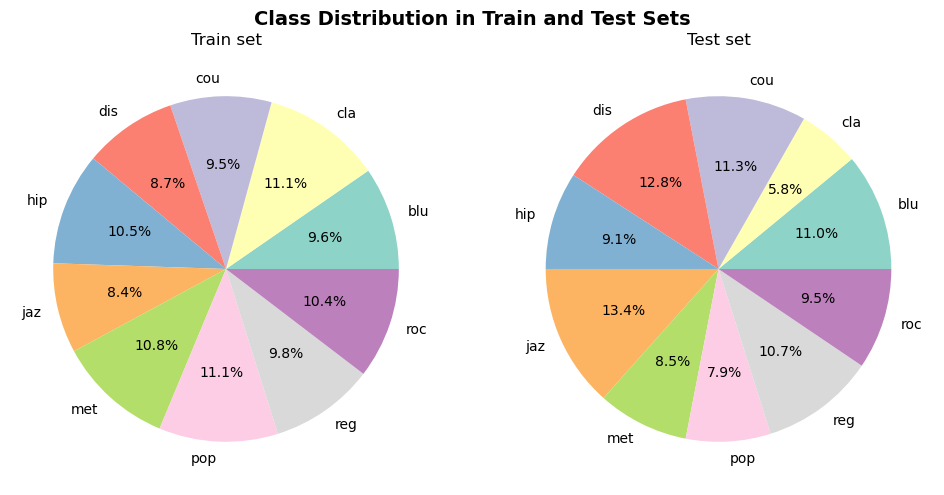

In [82]:
# check that the random split is representative

# Invert tag dictionary (int -> string)
inv_genre_dic = {v: k for k, v in genre_dict.items()}

# Count occurrences
train_counts = y_train.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

# Convert to label names using the inverted map
train_labels = [inv_genre_dic[i] for i in train_counts.index]
test_labels = [inv_genre_dic[i] for i in test_counts.index]


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# --- Train pie ---
wedges1, _,_ = axes[0].pie(

    train_counts,
    autopct='%1.1f%%',
    labels=train_labels,
    colors=colors[:len(train_labels)],
)
axes[0].set_title('Train set')

# --- Test pie ---
wedges2, _,_ = axes[1].pie(
    test_counts,
    autopct='%1.1f%%',
    labels=train_labels,
    colors=colors[:len(test_labels)],
)
axes[1].set_title('Test set')

fig.suptitle('Class Distribution in Train and Test Sets', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Logistic Regression

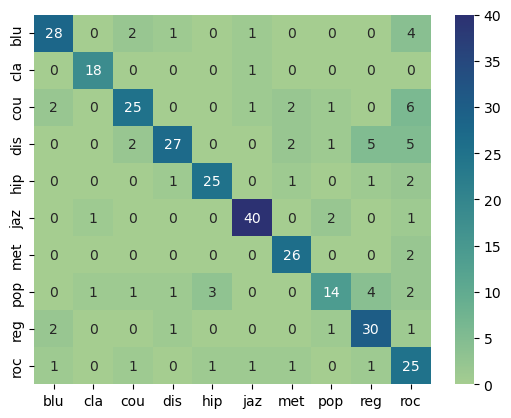

In [27]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf.score(X_test, y_test)

label_names = [i for i in genre_dict.keys()]
singleClass_cm = multilabel_confusion_matrix(y_test, y_pred,
                            labels=genreAll.genre.unique()) #tn, fn, fp, tp

cm = confusion_matrix(y_test, y_pred,
                            labels=genreAll.genre.unique()) #tn, fn, fp, tp
df_cfm = pd.DataFrame(cm, index=label_names, columns=label_names)
cfm_plot = sn.heatmap(df_cfm,annot=df_cfm, fmt="",cmap="crest")



In [34]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
kf = KFold(n_splits=10)
score = cross_val_score(clf, X_train,y_train, cv=kf)
#score = cross_validate(clf, X_train,y_train, cv=kf, scoring=['accuracy', 'f1_micro'])
print(f"Avg acc: {score.mean()}, avg sd: {score.std()}")


Avg acc: 0.8152419719583899, avg sd: 0.041536816224726526


/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## k-Nearest Neigbours

In [11]:
from sklearn.neighbors import KNeighborsClassifier

kn_score = []
for k in range(1,51,1):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    #pred_y = neigh.predict(X_test)
    kn_score.append(neigh.score(X_test,y_test ))


kn_score_dist = []
for k in range(1,51,1):
    neigh = KNeighborsClassifier(n_neighbors=k, weights='distance') #weight points by the inverse of their distance
    neigh.fit(X_train, y_train)
    #pred_y = neigh.predict(X_test)
    kn_score_dist.append(neigh.score(X_test,y_test ))


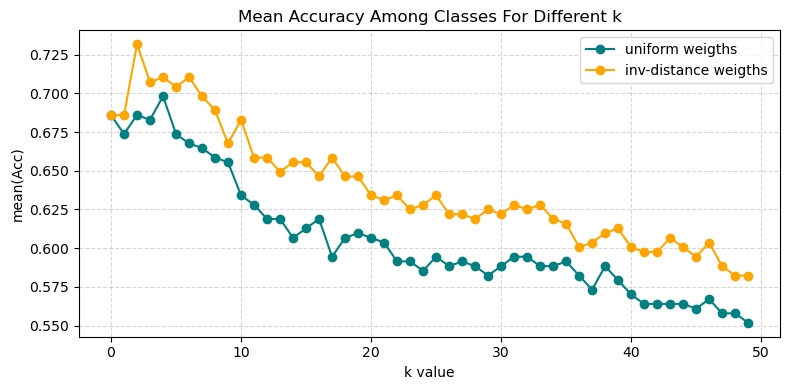

Best AccScore for uniformly weigthed distances: 0.6982 (k = 4)
Best AccScore for inv-dist weigthed distances: 0.7317 (k = 2)


In [12]:
plt.figure(figsize=(8, 4))
plt.plot(kn_score,'o-', color='teal', label='uniform weigths')
plt.plot(kn_score_dist,'o-', color='orange', label='inv-distance weigths')

plt.title("Mean Accuracy Among Classes For Different k")
plt.xlabel("k value")
plt.ylabel("mean(Acc)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best AccScore for uniformly weigthed distances: {max(kn_score):.4f} (k = {np.argmax(kn_score)})")
print(f"Best AccScore for inv-dist weigthed distances: {max(kn_score_dist):.4f} (k = {np.argmax(kn_score_dist)})")



## Desicion trees

In [13]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print(acc)
cross_val_score(clf, X_test,y_test, cv=10)

#tree.plot_tree(clf)

0.5823170731707317


array([0.45454545, 0.51515152, 0.39393939, 0.48484848, 0.63636364,
       0.60606061, 0.48484848, 0.39393939, 0.40625   , 0.40625   ])

## Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
kf = KFold(n_splits=10)
score = cross_val_score(clf, X_train,y_train, cv=kf)
#clf.score(X_test, y_test)
score

array([0.7761194 , 0.8358209 , 0.73134328, 0.80597015, 0.71641791,
       0.77272727, 0.8030303 , 0.8030303 , 0.84848485, 0.8030303 ])

## Multi Layer Perceptron

In [37]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)


0.7957317073170732

# Feature extractions: 
### correlation matrix of specific variables?
